<a href="https://colab.research.google.com/github/KwonHo-geun/AI_Study/blob/main/25.07.22_Deeplabv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os

# @markdown Download the full Pascal VOC dataset or download only 6 randomly chosen test images for inference.
Download_VOC_dataset = True #@param {type:"boolean"}

if Download_VOC_dataset:
    print("Downloading Pascal VOC 2012 dataset...")
    if not os.path.exists(r"/content/VOCtrainval_11-May-2012.tar"):
        !wget -qnc http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
        !tar -xf /content/VOCtrainval_11-May-2012.tar
else:
    print("Downloading 6 test images from the Pascal VOC 2012 dataset ...")
    os.makedirs("test_images", exist_ok=True)
    !wget -qnc https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3_test_2008_008746.jpg -P test_images
    !wget -qnc https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3_test_2009_002265.jpg -P test_images
    !wget -qnc https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3_test_2007_001311.jpg -P test_images
    !wget -qnc https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3_test_2007_007996.jpg -P test_images
    !wget -qnc https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3_test_2007_008222.jpg -P test_images
    !wget -qnc https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3_test_2008_006325.jpg -P test_images

In [2]:
# Necessary Imports

import os
import cv2
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# RGB color tuple for each class

# https://gist.github.com/wllhf/a4533e0adebe57e3ed06d4b50c8419ae
# https://gist.github.com/ccj5351/ae554ea70cef79ab1efdb3f9f92d2b37

label_map = np.array([
    (0, 0, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 128, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128),  # tv/monitor
])

In [5]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()

    # Create Numpy arrays containing zeros.
    # Later to be used to fill them with respective red, green, and blue pixels.

    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(label_map)):
        index = labels == label_num

        R, G, B = label_map[label_num]

        red_map[index] = R
        green_map[index] = G
        blue_map[index] = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)

    return image

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights,
                                             DeepLabV3_ResNet101_Weights,
                                             DeepLabV3_MobileNet_V3_Large_Weights
                                             )

def load_model(model_name: str):
    if model_name.lower() not in ("mobilenet", "resnet_50", "resnet_101"):
        raise ValueError("'model_name' should be one of ('mobilenet', 'resnet_50', 'resnet_101')")

    if model_name == "resnet_50":
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    elif model_name == "resnet_101":
        model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
        transforms = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    else:
        model = deeplabv3_mobilenet_v3_large(weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)
        transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()

    model.eval()

    # Warmup run

    _ = model(torch.randn(1, 3, 520, 520))

    return model, transforms

In [7]:
def perform_inference(model_name: str, num_images=6, image_dir=None, save_images=False, device=None):

    if save_images:
        seg_map_save_dir = os.path.join("results", model_name, "segmentation_map")
        overlayed_save_dir = os.path.join("results", model_name, "overlayed_images")

        os.makedirs(seg_map_save_dir, exist_ok=True)
        os.makedirs(overlayed_save_dir, exist_ok=True)


    device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
    model, transforms = load_model(model_name)
    model.to(device)

    # Load image handles for the validation set.
    if Download_VOC_dataset:
        with open(r"/content/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt") as f:
            image_names = f.read().split("\n")

    else:
        image_names = os.listdir(image_dir)

    # Randomly select 'num_images' from the whole set for inference.
    selected_images = np.random.choice(image_names, num_images, replace=False)

    # Iterate over selected images
    for img_handle in selected_images:

        # Load and pre-process image.
        image_name, ext = os.path.splitext(img_handle)
        image_name = img_handle if ext else f"{img_handle}.jpg"

        image_path = os.path.join(image_dir, image_name)
        img_raw = PIL.Image.open(image_path).convert("RGB")
        W, H = img_raw.size[:2]
        img_t = transforms(img_raw)
        img_t = torch.unsqueeze(img_t, dim=0).to(device)

        # Model Inference
        with torch.no_grad():
            output = model(img_t)["out"].cpu()

        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)

        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
        overlayed_image = image_overlay(img_raw, segmented_image)

        # Plot
        plt.figure(figsize=(12, 10), dpi=100)
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Image")
        plt.imshow(np.asarray(img_raw))

        plt.subplot(1, 3, 2)
        plt.title("Segmentation")
        plt.axis("off")
        plt.imshow(segmented_image)

        plt.subplot(1, 3, 3)
        plt.title("Overlayed")
        plt.axis("off")
        plt.imshow(overlayed_image[:, :, ::-1])

        plt.show()
        plt.close()

        # Save Segmented and overlayed images
        if save_images:
            cv2.imwrite(seg_map_save_dir, segmented_image[:, :, ::-1])
            cv2.imwrite(overlayed_save_dir, overlayed_image)

    return

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 118MB/s]


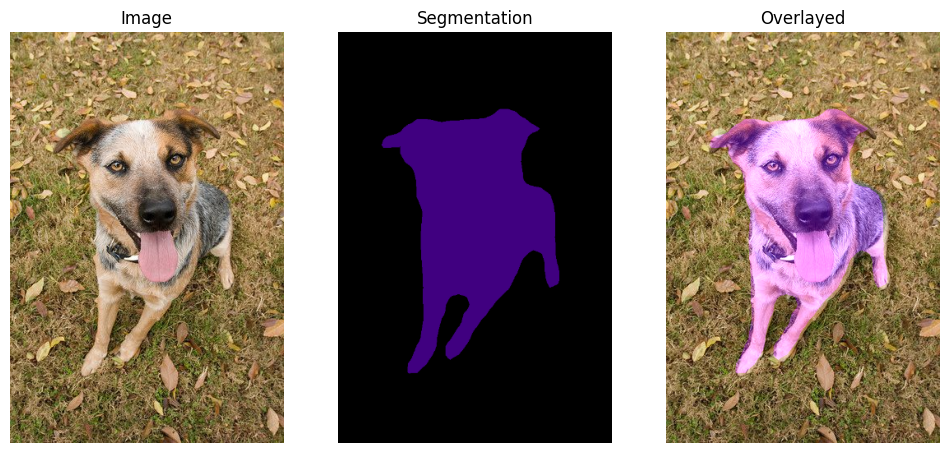

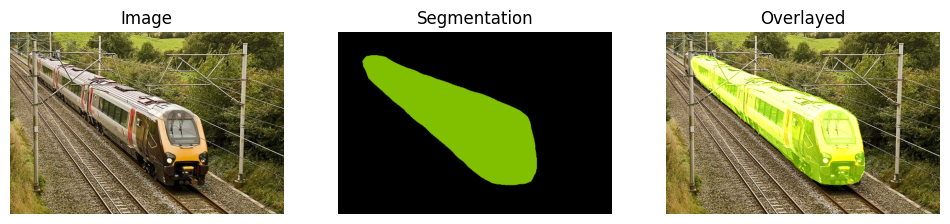

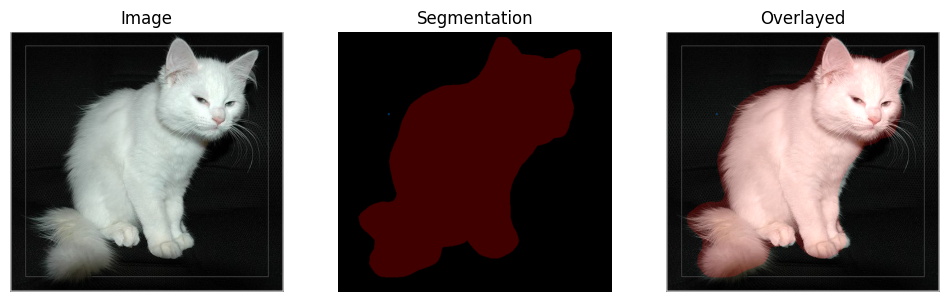

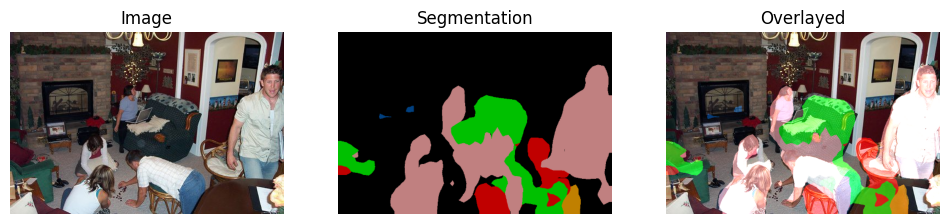

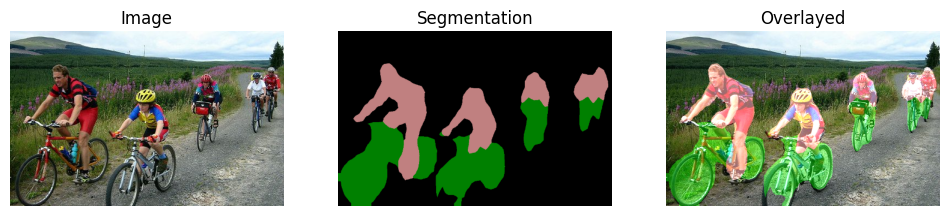

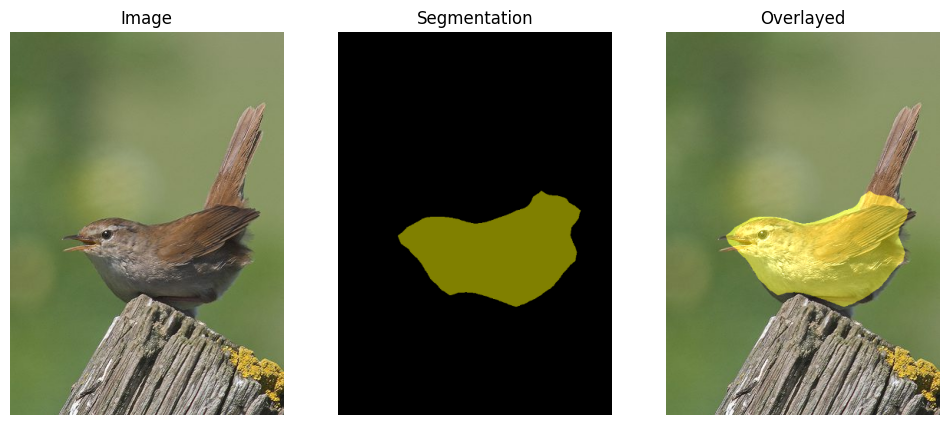

In [8]:
if Download_VOC_dataset:
    ROOT_raw_image_directory = r"/content/VOCdevkit/VOC2012/JPEGImages"
else:
    ROOT_raw_image_directory = r"/content/test_images"

model_name = 'mobilenet' # "mobilenet", "resnet_50", resnet_101
num_images = 6
save = False

perform_inference(
    model_name=model_name,
    num_images=num_images,
    save_images=save,
    image_dir=ROOT_raw_image_directory
)